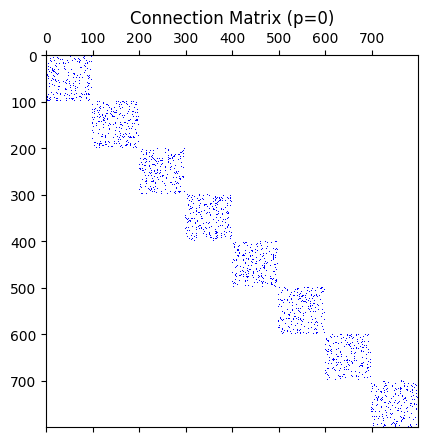

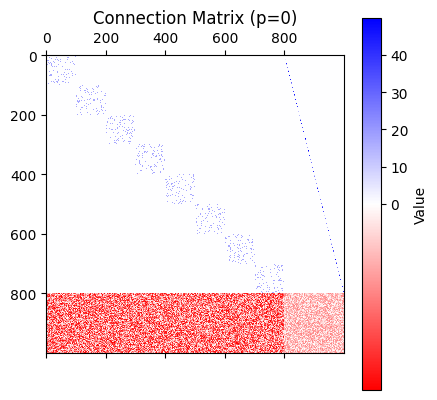

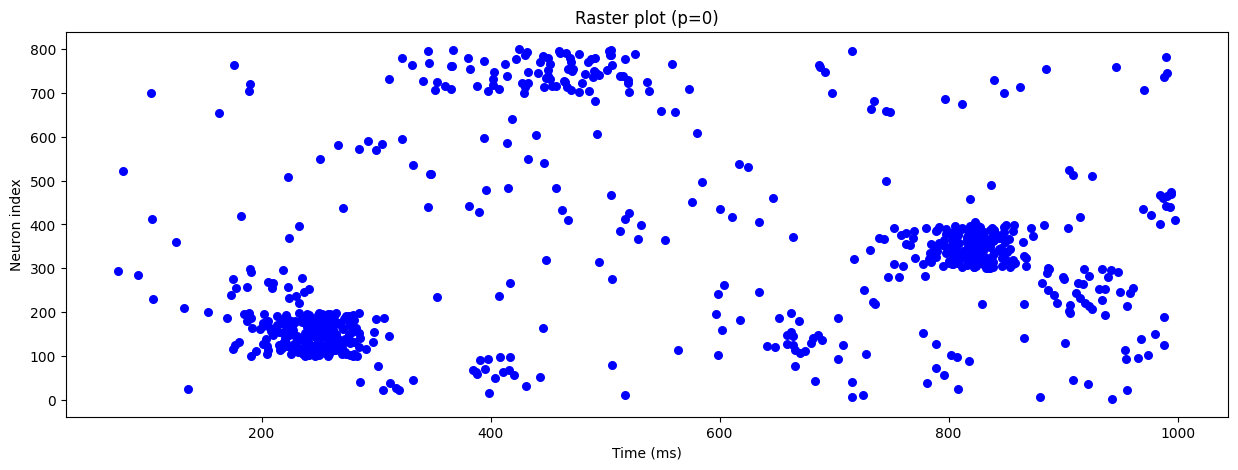

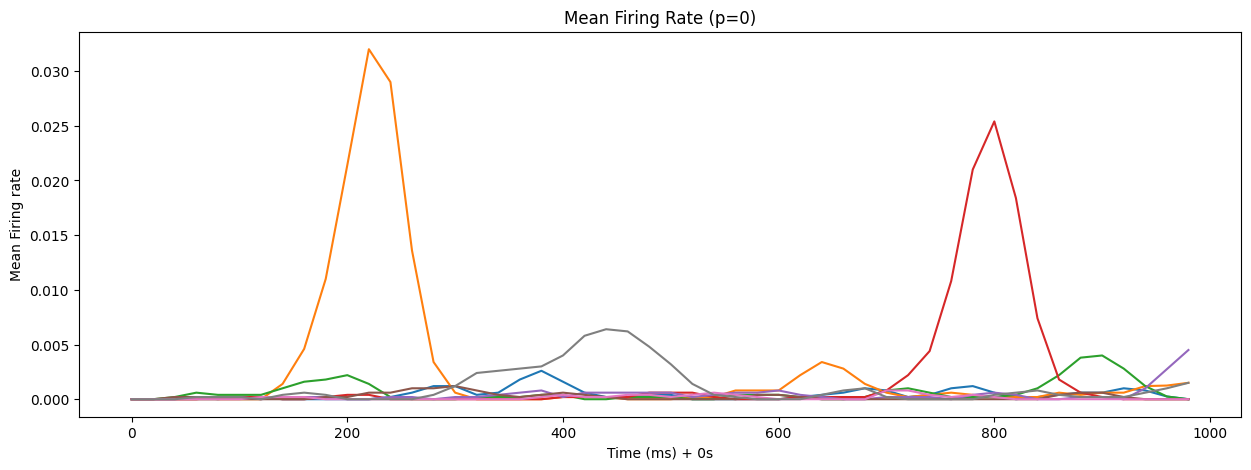

In [189]:
from iznetwork import IzNetwork
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

N_MODULE = 8
N_MODULE_EXCITATORY = 100
N_EXCITATORY = N_MODULE_EXCITATORY * N_MODULE
N_INHIBITORY = 200

N_MODULE_EDGE = 1000

N = N_INHIBITORY + N_EXCITATORY

EtoE_SCALING_FACTOR = 17
EtoI_SCALING_FACTOR = 50
ItoE_SCALING_FACTOR = 2
ItoI_SCALING_FACTOR = 1

p = 0
poissonLambda = 0.01

Dmax = 20
net = IzNetwork(N, Dmax)

# Set connectivity and delay matrices
W = np.zeros((N,N))
D = np.ones((N,N), dtype=int)
D[:N_EXCITATORY, :N_EXCITATORY] = np.random.uniform(1, 20, size=(N_EXCITATORY, N_EXCITATORY))

# Connect Modular Excitatory-excitatory (1000 Connections)
for i in range(N_MODULE):
    matrix = np.zeros((N_MODULE_EXCITATORY, N_MODULE_EXCITATORY))

    # All index pairs excluding self-connections
    all_pairs = [(row, col) for row in range(N_MODULE_EXCITATORY) 
                 for col in range(N_MODULE_EXCITATORY) if row != col]
    
    selected_pairs = random.sample(all_pairs, N_MODULE_EDGE)
    for row, col in selected_pairs:
        matrix[row, col] = 1
    
    W[i * N_MODULE_EXCITATORY:(i + 1) * N_MODULE_EXCITATORY, i * N_MODULE_EXCITATORY:(i + 1) * N_MODULE_EXCITATORY] = matrix

# Connect Excitatory-inhibitory (4 to 1)
for i in range(N_INHIBITORY):
    for index in range(4):
        W[i * 4 + index][N_EXCITATORY + i] = random.uniform(0.0, 1.0)
    
# Connect Inhibitory-excitatory
W[N_EXCITATORY:, :N_EXCITATORY] = np.random.uniform(-1, 0, size=(N_INHIBITORY, N_EXCITATORY))

# Connect Inhibitory-inhibitory
W[N_EXCITATORY:, N_EXCITATORY:] = np.random.uniform(-1, 0, size=(N_INHIBITORY, N_INHIBITORY))
# Avoid Inhibitory-inhibitory self-connections
np.fill_diagonal(W[N_EXCITATORY:, :N_EXCITATORY], 0)

# Rewire Excitatory-excitatory
for s in range(N_EXCITATORY):
    for t in range(N_EXCITATORY):
        # Have connection
        if W[s, t] == 0:
            continue

        if np.random.random() < p:
            W[s, t] = 0

            new_target = s
            while s // N_MODULE_EXCITATORY == new_target // N_MODULE_EXCITATORY:
                new_target = np.random.randint(N_EXCITATORY)

            W[s, new_target] = 1

colors = ['white', 'blue'] 
cmap = mcolors.LinearSegmentedColormap.from_list('white_blue', colors)
plt.matshow(W[:N_EXCITATORY, :N_EXCITATORY], cmap=cmap)
plt.title(f"Connection Matrix (p={p})")
plt.show()

# Include Scaling Factor
W[:N_EXCITATORY, :N_EXCITATORY] *= EtoE_SCALING_FACTOR
W[:N_EXCITATORY, N_EXCITATORY:] *= EtoI_SCALING_FACTOR
W[N_EXCITATORY:, :N_EXCITATORY] *= ItoE_SCALING_FACTOR
W[N_EXCITATORY:, N_EXCITATORY:] *= ItoI_SCALING_FACTOR

# Weights Plot
vmin, vmax = W.min(), W.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
colors = ['red', 'white', 'blue'] 
cmap = mcolors.LinearSegmentedColormap.from_list('red_white_blue', colors)
plt.matshow(W, cmap=cmap, norm=norm, interpolation='nearest')
plt.colorbar(label="Value")
plt.title(f"Connection Matrix (p={p})")
plt.show()


# All neurons are heterogeneous excitatory regular spiking
r = np.random.rand(N)
a = 0.02*np.ones(N)
b = np.ones(N)
c = -65 + 15*(r**2)*np.ones(N)
d = np.ones(N)

# Excitatory
b[:N_EXCITATORY] = 0.2
d[:N_EXCITATORY] = 8

# Inhibitory
b[N_EXCITATORY:] = 0.25
d[N_EXCITATORY:] = 2

net.setWeights(W)
net.setDelays(D)
net.setParameters(a, b, c, d)

# Raster Plot
T = 1000
V = np.zeros((T, N))
for t in range(T):
    net.setCurrent((np.random.poisson(poissonLambda, N) > 0) * 15)
    net.update()
    V[t,:], _ = net.getState()

t, n = np.where(V[:,:N_EXCITATORY] > 29)
plt.figure(figsize=(15, 5))
plt.scatter(t, n, s=30, c='blue')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title(f"Raster plot (p={p})")
plt.show()

# Mean Firing Rate
interval = 20
MFR = np.zeros((T // interval, N_MODULE))
window = 50
for t in range(0, T, interval):
    for m in range(N_MODULE):
        matrix = V[t:t+window, m * N_MODULE_EXCITATORY:(m+1) * N_MODULE_EXCITATORY]
        MFR[t // interval][m] = np.count_nonzero(matrix > 29) / matrix.size

plt.figure(figsize=(15, 5))
plt.plot(range(0, T, interval), MFR[:])
plt.xlabel('Time (ms) + 0s')
plt.ylabel('Mean Firing rate')
plt.title(f"Mean Firing Rate (p={p})")
plt.show()


        